In [4]:
# ---------------------------------------------------------------
# Script de Preparación de Datos
# ---------------------------------------------------------------
import pandas as pd

# Import packages for data modelling
from sklearn.model_selection import train_test_split, GridSearchCV

data = pd.read_csv("../data/tiktok_dataset.csv")

# Eliminar los valores en nulo
data = data.dropna(axis=0)

# Creating `text_length` column
data['text_length'] = data['video_transcription_text'].str.len()





In [5]:
# X = data.copy()
# Dropping unnecessary columns
data = data.drop(['#', 'video_id'], axis=1)
# Encoding target variable
data['claim_status'] = data['claim_status'].replace({'opinion': 0, 'claim': 1})
# Dummy encode remaining categorical values
data = pd.get_dummies(data,columns=['verified_status', 'author_ban_status'],drop_first=True)


# Splitting the data into training and testing sets
X_tr, X_test = train_test_split(data, test_size=0.2, random_state=0)

print (X_tr)

       claim_status  video_duration_sec  \
4874              1                  37   
1569              1                   7   
479               1                  21   
14161             0                  52   
14846             0                  45   
...             ...                 ...   
9225              1                  51   
13123             0                  31   
9845              0                  32   
10799             0                  28   
2732              1                  28   

                                video_transcription_text  video_view_count  \
4874   i learned  on a website that the busiest airpo...          743307.0   
1569   a friend learned  online that ketchup leaves t...          198806.0   
479    the news mentioned someone discovered that the...           60649.0   
14161  my friends' sentiment is that the first cricke...              86.0   
14846  my family's opinion is that at the first moder...            7930.0   
...            

C:\Users\ARMANDO\AppData\Local\Temp\ipykernel_14316\610688597.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['claim_status'] = data['claim_status'].replace({'opinion': 0, 'claim': 1})


In [12]:
import pandas as pd
import os

# Import packages for data modelling
from sklearn.model_selection import train_test_split, GridSearchCV

def preparar_datos(data):
    data = data.dropna(axis=0)
    data['text_length'] = data['video_transcription_text'].str.len()
    data = data.drop(['#', 'video_id'], axis=1)
    data['claim_status'] = data['claim_status'].replace({'opinion': 0, 'claim': 1})
    data = pd.get_dummies(data,columns=['verified_status', 'author_ban_status'],drop_first=True)
    return data

def dividir_datos(data):
    data_list = []
    # Dividir los datos en conjuntos de entrenamiento y de prueba
    data_tr, data_test = train_test_split(data, test_size=0.2, random_state=0)

    # Dividir los datos de entrenamiento en conjuntos de entrenamiento y validación
    data_train, data_val = train_test_split(data_tr, test_size=0.25, random_state=0)

    data_list.append(data_train)
    data_list.append(data_test)
    data_list.append(data_val)
    return data_list

def exportar_datos(data_list):
    data_list[0].to_csv(os.path.join('../data/processed/data_train.csv'))
    data_list[1].to_csv(os.path.join('../data/processed/data_test.csv'))
    data_list[2].to_csv(os.path.join('../data/processed/data_val.csv'))

def main():
    # Importar archivo
    data = pd.read_csv("../data/raw/tiktok_dataset.csv")
    # Preparar datos
    data = preparar_datos(data)
    # Dividir datos en entrenamiento, prueba y validación
    data_list = dividir_datos(data)
    # Exportar datos
    exportar_datos(data_list)


In [13]:
main()

C:\Users\ARMANDO\AppData\Local\Temp\ipykernel_14316\2237388827.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['text_length'] = data['video_transcription_text'].str.len()
C:\Users\ARMANDO\AppData\Local\Temp\ipykernel_14316\2237388827.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['claim_status'] = data['claim_status'].replace({'opinion': 0, 'claim': 1})


In [87]:
# ---------------------------------------------------------------
# Script de Entrenamiento - Modelo de 
# ---------------------------------------------------------------

import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
import pickle
import os

import warnings
warnings.filterwarnings('ignore')

# Cargar la tabla transformada
def importar_train(filename):
    df = pd.read_csv(os.path.join('../data/processed', filename))
    X_train = df.drop(['claim_status'],axis=1)
    y_train = df[['claim_status']]
    return X_train, y_train

def entrenar_modelo(X_train,y_train,cv_params):
    scoring = ['accuracy', 'precision', 'recall', 'f1']
    rf = RandomForestClassifier(random_state=0)
    rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit='recall')

    # Tokenizar las columnas
    count_vec = CountVectorizer(ngram_range=(2, 3),max_features=15,stop_words='english')
    count_data = count_vec.fit_transform(X_train['video_transcription_text']).toarray()
    count_df = pd.DataFrame(data=count_data, columns=count_vec.get_feature_names_out())
    X_train_final = pd.concat([X_train.drop(columns=['video_transcription_text']).reset_index(drop=True), count_df], axis=1)
    X_train_final.drop(columns=['colleague discovered', 'discovered news'], errors='ignore', inplace=True)

    rf_mod = rf_cv.fit(X_train_final, y_train)
    print('Modelo entrenado')
    return rf_mod
    
def guardar_modelo(rf_mod):
    package = '../model/best_model.pkl'
    pickle.dump(rf_mod, open(package, 'wb'))
    print('Modelo exportado correctamente en la carpeta model')

# Entrenamiento completo
def main():
    cv_params = {'max_depth': [5, 7, None],
                'max_features': [0.3, 0.6],
                'max_samples': [0.7],
                'min_samples_leaf': [1,2],
                'min_samples_split': [2,3],
                'n_estimators': [75,100,200],
                }
    X_train, y_train = importar_train('data_train.csv')
    rf_mod = entrenar_modelo(X_train,y_train,cv_params)
    guardar_modelo(rf_mod)
    print('Finalizó el entrenamiento del Modelo')

In [88]:
main()

Modelo entrenado
Modelo exportado correctamente en la carpeta model
Finalizó el entrenamiento del Modelo


In [100]:
# ---------------------------------------------------------------
# Script de Entrenamiento - Modelo de 
# ---------------------------------------------------------------

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import *
import pickle
import os

import warnings
warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"] = [12, 5]

# Cargar la tabla transformada
def importar_test(filename):
    df = pd.read_csv(os.path.join('../data/processed', filename))
    X_val = df.drop(['claim_status'],axis=1)
    y_val = df[['claim_status']]
    return X_val, y_val

def importar_modelo():
    package = '../model/best_model.pkl'
    model = pickle.load(open(package, 'rb'))
    print('Modelo importado correctamente')
    return model

def mostrar_matriz_confusion(y_val,y_pred_test):
    log_cm = confusion_matrix(y_val,y_pred_test)
    log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)
    log_disp.plot()
    plt.show()

def imprimir_metricas(y_val,y_pred_test):
    target_labels = ['opinion', 'claim']
    accuracy_test=accuracy_score(y_val,y_pred_test)
    precision_test=precision_score(y_val,y_pred_test)
    recall_test=recall_score(y_val,y_pred_test)

    print("Matriz de confusion: ")
    print("Accuracy: ", accuracy_test)
    print("Precision: ", precision_test)
    print("Recall: ", recall_test)
    print(classification_report(y_val, y_pred_test, target_names=target_labels))

def main():
    X_val, y_val = importar_test('data_test.csv')

    # Tokenizar las columnas
    count_vec = CountVectorizer(ngram_range=(2, 3),max_features=15,stop_words='english')
    validation_count_data = count_vec.fit_transform(X_val['video_transcription_text']).toarray()
    validation_count_df = pd.DataFrame(data=validation_count_data, columns=count_vec.get_feature_names_out())
    validation_count_df = validation_count_df.drop(columns=['willing say'])
    X_val_final = pd.concat([X_val.drop(columns=['video_transcription_text']).reset_index(drop=True), validation_count_df.drop(columns=['internet forum claim']).reset_index(drop=True)], axis=1)
    model = importar_modelo()
    y_pred_test = model.best_estimator_.predict(X_val_final)
    print('Finalizó el entrenamiento del Modelo')
    mostrar_matriz_confusion(y_val,y_pred_test)
    imprimir_metricas(y_val,y_pred_test)

# if __name__ == "__main__":
#     main()

Modelo importado correctamente
Finalizó el entrenamiento del Modelo


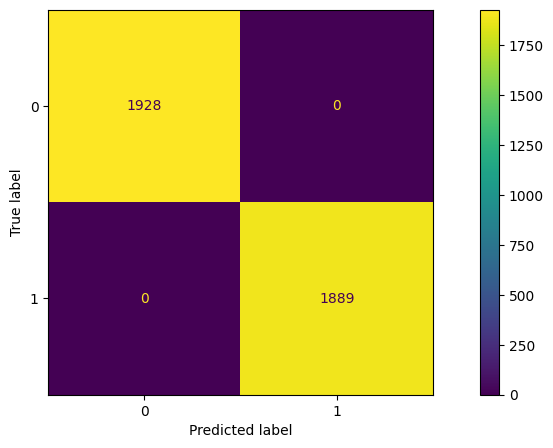

Matriz de confusion: 
Accuracy:  1.0
Precision:  1.0
Recall:  1.0
              precision    recall  f1-score   support

     opinion       1.00      1.00      1.00      1928
       claim       1.00      1.00      1.00      1889

    accuracy                           1.00      3817
   macro avg       1.00      1.00      1.00      3817
weighted avg       1.00      1.00      1.00      3817



In [101]:
main()